# Clickbait Titles
_____________

# Part 2 - Modeling

### Riche Ngo


In [33]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from scipy import sparse
from datetime import datetime

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, plot_roc_curve, precision_recall_fscore_support
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

### Import data

In [3]:
# Load dataframe
infile = open('../datasets/clickbait_headlines/clickbait_df_processed.pkl','rb')
df = pickle.load(infile)
infile.close()

In [4]:
df.head()

,title,clickbait,title_length,num_stopwords
0,should i get bings,1,4,2
1,which tv female friend group do you belong in,1,9,4
2,the new star wars the force awakens trailer is...,1,14,6
3,this vine of new york on celebrity big brother...,1,12,4
4,a couple did a stunning photo shoot with their...,1,18,9


In [6]:
df.shape

(32000, 4)

In [5]:
# Check null values
df.isnull().sum()

title            0
clickbait        0
title_length     0
num_stopwords    0
dtype: int64

## Data Preparation

We want to convert the textual data into numerical data before we start fitting the models. We use sklearn's `TfidfVectorizer` to do so.

In [7]:
# Split into train and test (hold-out) data
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [8]:
# Instantiate vectorizer
tvec = TfidfVectorizer(min_df=3, ngram_range=(1,5))

# Fit and transform textual data
X_train_tvec = tvec.fit_transform(df_train['title'])
X_test_tvec = tvec.transform(df_test['title'])

For the engineered features, they are already numerical, we just need to scale them.

In [11]:
# Scale engineered features
ss = StandardScaler()
X_train_val = ss.fit_transform(df_train[['title_length', 'num_stopwords']])
X_test_val = ss.transform(df_test[['title_length', 'num_stopwords']])

We want to combine the word vectors with the scaled engineered features into sparse arrays. Sparse arrays will save memory.

In [13]:
X_train = sparse.hstack([X_train_tvec, X_train_val]).tocsr()
X_test = sparse.hstack([X_test_tvec, X_test_val]).tocsr()

In [48]:
y_train = df_train['clickbait']
y_test = df_test['clickbait']

## Modelling

In [49]:
# Function to run the models using Gridsearch
# Scoring optimized on accuracy by default

def run_gs_models(models, model_params):
    gs_models = []
    model_scores = []
    
    print('Training...\n-------------------')
    
    for m_key, model in models.items():
        
        # Instantiate GridSearchCV 5-fold
        gs = GridSearchCV(model, param_grid = model_params[m_key], cv=5)
        
        t0 = datetime.now()
        print(f'Model start run... {model}')
        # Fit GridSearch to training data
        gs.fit(X_train, y_train)
        print(f'Done! Runtime - {datetime.now() - t0}')
        
        # Append to the lists
        model_scores.append(gs.best_score_)
        gs_models.append(gs)
        
    print('ALL DONE!\n-------------------')
    
    return gs_models, model_scores    

In [55]:
# Set up for all models to be run
models = {
    'lr': LogisticRegression(max_iter=5_000),
    'nb': BernoulliNB(),
    'rf': RandomForestClassifier(random_state=42),
    'et': ExtraTreesClassifier(random_state=42),
    'ada': AdaBoostClassifier(random_state=42),
    'gboost': GradientBoostingClassifier(),
    'svc': SVC()
}

# Set up all the hyperparameters to Gridsearch
model_params = {
    'lr': {'C': np.linspace(0.1, 1, 5)},
    'nb': {'alpha': [0.9, 1, 1.1]},
    'rf': {'n_estimators': [80, 100, 120],
           'max_depth': [3, 5, 7],
           'min_samples_leaf': [2, 4],
           'min_samples_split' : [2, 3, 4]},
    'et': {'n_estimators': [80, 100, 120],
           'max_depth': [3, 5, 7],
           'min_samples_leaf': [2, 4],
           'min_samples_split' : [2, 4, 5]},
    'ada': {'n_estimators': [20, 30, 40, 50],
            'learning_rate': [0.8, 1]},
    'gboost': {'n_estimators': [80, 100, 120],
               'max_depth': [2, 3],
               'min_samples_split': [2, 4]},
    'svc': {'C': np.linspace(0.1, 1, 5)}
}

# Names of models
model_name = ['Logistic Regression',
             'Naive Bayes',
             'Random Forest',
             'Extra Trees',
             'AdaBoost',
             'GradientBoosting',
             'Support Vector']

In [56]:
# Run the models
gs_models, model_scores = run_gs_models(models, model_params)

Training...
-------------------
Model start run... LogisticRegression(max_iter=5000)
Done! Runtime - 0:00:14.470342
Model start run... BernoulliNB()
Done! Runtime - 0:00:00.315158
Model start run... RandomForestClassifier(random_state=42)
Done! Runtime - 0:02:49.804154
Model start run... ExtraTreesClassifier(random_state=42)
Done! Runtime - 0:02:43.785686
Model start run... AdaBoostClassifier(random_state=42)
Done! Runtime - 0:01:37.891871
Model start run... GradientBoostingClassifier()
Done! Runtime - 0:09:44.512500
Model start run... SVC()
Done! Runtime - 0:23:35.721579
ALL DONE!
-------------------


In [58]:
# Save the files just in case
pickle.dump(gs_models, open('gs_models.pkl', 'wb'))
pickle.dump(model_scores, open('model_scores.pkl', 'wb'))

In [59]:
# View the evaluation metrics for all models in a dataframe
# Sorted by highest accuracy
precision_list = []
recall_list = []
fscore_list = []
for model in gs_models:
    y_pred = model.predict(X_test)
    precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='macro')
    precision_list.append(precision)
    recall_list.append(recall)
    fscore_list.append(fscore)

pd.DataFrame({'Model Type': model_name,
             'CV Score': model_scores,
             'Precision': precision_list,
             'Recall': recall_list,
             'F1-Score': fscore_list}).sort_values(by='CV Score', ascending=False)

,Model Type,CV Score,Precision,Recall,F1-Score
1,Naive Bayes,0.967969,0.968219,0.968281,0.967812
6,Support Vector,0.965195,0.966962,0.967125,0.967021
0,Logistic Regression,0.960273,0.960602,0.960840,0.960619
5,GradientBoosting,0.908047,0.905866,0.905997,0.905623
4,AdaBoost,0.907070,0.904224,0.902290,0.901188
2,Random Forest,0.882500,0.894809,0.883261,0.880424
3,Extra Trees,0.864453,0.888738,0.872244,0.868571


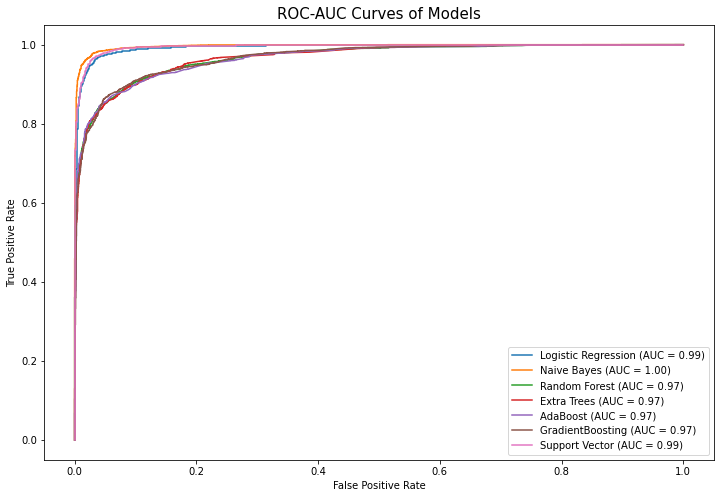

In [60]:
# Plotting the ROC curves for every model
plt.figure(figsize=(12,8))
ax = plt.gca()
for model, m_name in zip(gs_models, model_name):
    plot_roc_curve(model, X_test, y_test, name=m_name, ax=ax)
plt.title('ROC-AUC Curves of Models', fontsize=15);

In [61]:
# Function to plot multiple confusion matrix
def subplot_confusion_matrix(model_list, model_name, X_test, y_test):
    nrows = int(np.ceil(len(model_list)/3))   # Ensure have enough rows
    fig, ax = plt.subplots(nrows=nrows, ncols=3, figsize=(14, nrows*4))   
    plt.subplots_adjust(hspace = 0.4)
    ax = ax.ravel()   # Ravel turns a matrix into a vector, which is easier to iterate
    for i, model in enumerate(model_list):   # Gives us an index value to get into all our lists
        plot_confusion_matrix(model, X_test, y_test, cmap='Blues', values_format='d', ax=ax[i])
        ax[i].set_title(model_name[i])
    
        # display scale and label only on the left edge
        if i%3 != 0:
            ax[i].set_ylabel('')
            ax[i].set_yticklabels('')
    # This code below is to switch off the axes if there is an odd number of subplots
    for axes in ax.flat[len(model_list):]:
        axes.axis('off')
    fig.tight_layout()
    pass

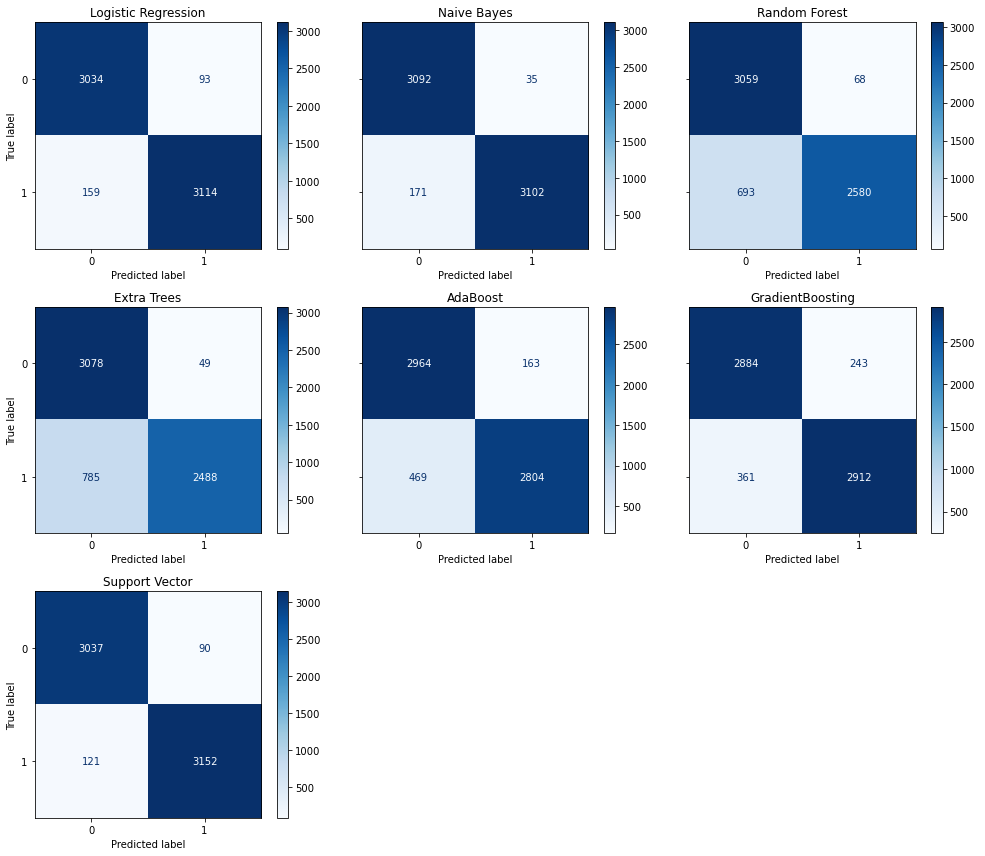

In [62]:
# Plotting confusion matrix for all models
subplot_confusion_matrix(gs_models, model_name, X_test, y_test)